<a href="https://colab.research.google.com/github/AfsanehHabibi/reddit-conversation-quality/blob/main/Conversation_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
base_path = "/content/drive/MyDrive/University/RedditData/"

In [71]:
import pickle

with open(f"{base_path}conversations_with_topics_dataframe.pkl", 'rb') as file:
    df = pickle.load(file)

In [72]:
df = df.rename(columns={'politensess': 'politeness'})

In [73]:
import numpy as np

df['subreddit_subscribers'] = df['subreddit_subscribers'].replace(0, np.nan)

#Conversation-addation

In [74]:
df['conv-unweighted'] = df['norm_readability'] + df['norm_politeness'] + df['has_reasoning'] + df['evidence'] + df['relatedness']

In [75]:
df['conv-eq-maxim'] = 0.5*df['norm_readability'] + 0.5*df['norm_politeness'] + 0.5*df['has_reasoning'] + 0.5*df['evidence'] + df['relatedness']

#Column addition

In [76]:
df['reply_to'].nunique()

135904

In [77]:
def add_mean_for_reply(df, column):
  replies_df = df.loc[df['reply_to'].notnull()]
  mean_column = replies_df.groupby('reply_to')[column].mean()
  df = df.merge(mean_column.rename('mean_' + column + '_replies'), left_on='id', right_index=True, how='left')
  return df

In [78]:
df = add_mean_for_reply(df, 'norm_readability')
df = add_mean_for_reply(df, 'norm_politeness')
df = add_mean_for_reply(df, 'relatedness')
df = add_mean_for_reply(df, 'evidence')
df = add_mean_for_reply(df, 'has_reasoning')

In [79]:
maxim_mean_over_replies = ['mean_norm_readability_replies', 'mean_norm_politeness_replies', 'mean_has_reasoning_replies', 'mean_evidence_replies', 'mean_relatedness_replies']

In [80]:
def add_string_length(df, column):
    df['len_'+column] = df[column].apply(lambda x: len(x) if isinstance(x, str) else np.nan)
    return df

In [81]:
df = add_string_length(df, 'title')
df = add_string_length(df, 'text')

In [82]:
import numpy as np

def add_log(df, column):
  df['log_'+column] = np.log(df[column])
  return df

In [83]:
df = add_log(df, 'subreddit_subscribers')

In [84]:
df.head()

,id,conversation_id,reply_to,readability,evidence,has_reasoning,politeness,relatedness,subjectivity,polarity,...,conv-unweighted,conv-eq-maxim,mean_norm_readability_replies,mean_norm_politeness_replies,mean_relatedness_replies,mean_evidence_replies,mean_has_reasoning_replies,len_title,len_text,log_subreddit_subscribers
0,xyt38s,xyt38s,None,-0.5,0.5,0,0.095238,NaN,0.532381,0.224286,...,NaN,NaN,0.65,0.058824,0.306438,0.333333,0.0,12.0,282.0,8.821732
1,iromk5a,xyt38s,xyt38s,-0.5,0.5,0,0.095238,0.887727,0.532381,0.224286,...,2.455374,1.671550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.821732
2,irpc624,xyt38s,xyt38s,-4.5,0.5,0,0.000000,0.031587,0.000000,0.000000,...,1.081587,0.556587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.821732
3,irp3pvs,xyt38s,xyt38s,-5.5,0.0,0,0.047619,0.000000,0.400000,0.800000,...,0.508824,0.254412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.821732
4,xyt38b,xyt38b,None,-2.5,0.5,1,0.380952,NaN,0.415179,0.015476,...,NaN,NaN,1.00,0.294118,0.262232,0.500000,1.0,66.0,694.0,14.904485


#Plots

##Scatter plot

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def scatter(df, column1, column2):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=column1, y=column2, data=df)
    plt.xlabel(f'{column1} of Original Row')
    plt.ylabel(f'{column2}')
    plt.title(f'Relationship between Original {column1} and {column2}')
    plt.show()


##Boxplot

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def boxplots_for_categorical_to_numerical(df, column1, column2):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column1, y=column2, data=df, fliersize=3)

    # Get the unique categories
    categories = df[column1].unique()

    # Set the x-axis tick labels
    plt.xticks(range(len(categories)), categories, rotation=90)

    plt.title(f'Boxplot for {column1} in respect to {column2}')
    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.tight_layout()

    # the number of points in each boxplot
    #for i, box in enumerate(df.groupby(column1)[column2]):
    #   print(box[1].shape[0])

    plt.show()

##Density plot

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def density_for_numeric_to_numeric(df, column1, column2):
    plt.figure(figsize=(8, 6))
    sns.jointplot(x=column1, y=column2, data=df, kind='kde', cmap='viridis')
    plt.suptitle(f'Density between Original {column1} and {column2}')
    plt.tight_layout()
    plt.show()

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def density_for_numeric_to_numeric_simple(df, column1, column2):
    df['density'] = np.log1p(df.groupby([column1, column2])[column1].transform('count'))

    # Create a dummy scatter plot for colorbar mappable
    dummy = plt.scatter([], [], c=[], cmap='viridis', alpha=0.6, label='Density')

    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x=column1, y=column2, hue='density', data=df, palette='viridis', alpha=0.6)
    plt.xlabel(f'{column1} of Original Row')
    plt.ylabel(f'{column2}')
    plt.title(f'Relationship between Original {column1} and {column2}')
    plt.colorbar(dummy)
    plt.legend()
    plt.show()

##Heatmap

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(df, column1, column2):
  correlation = df[column1].corr(df[column2])

  plt.figure(figsize=(8, 6))
  sns.heatmap([[1, correlation], [correlation, 1]], annot=True, cmap='coolwarm', linewidths=.5, xticklabels=[column1, column2], yticklabels=[column1, column2])
  plt.title(f'Intensity Plot for Correlation between {column1} and {column2}')
  plt.show()

##Agreggation

In [56]:
#over correspond
def heatmap_and_density_for_correspond(column):
  density_for_numeric_to_numeric(df, column, 'norm_readability')
  heatmap_for_numeric_to_numeric(df, column, 'norm_readability')
  density_for_numeric_to_numeric(df, column, 'norm_politeness')
  heatmap_for_numeric_to_numeric(df, column, 'norm_politeness')
  density_for_numeric_to_numeric(df, column, 'has_reasoning')
  heatmap_for_numeric_to_numeric(df, column, 'has_reasoning')
  density_for_numeric_to_numeric(df, column, 'evidence')
  heatmap_for_numeric_to_numeric(df, column, 'evidence')
  density_for_numeric_to_numeric(df, column, 'relatedness')
  heatmap_for_numeric_to_numeric(df, column, 'relatedness')
  density_for_numeric_to_numeric(df, column, 'conv-unweighted')
  heatmap_for_numeric_to_numeric(df, column, 'conv-unweighted')
  density_for_numeric_to_numeric(df, column, 'conv-eq-maxim')
  heatmap_for_numeric_to_numeric(df, column, 'conv-eq-maxim')

In [57]:
#over mean of reply
def heatmap_and_density_for_maxims(column):
  density_for_numeric_to_mean_numeric(df, column, 'norm_readability')
  heatmap_for_numeric_to_mean_numeric(df, column, 'norm_readability')
  density_for_numeric_to_mean_numeric(df, column, 'norm_politeness')
  heatmap_for_numeric_to_mean_numeric(df, column, 'norm_politeness')
  density_for_numeric_to_mean_numeric(df, column, 'has_reasoning')
  heatmap_for_numeric_to_mean_numeric(df, column, 'has_reasoning')
  density_for_numeric_to_mean_numeric(df, column, 'evidence')
  heatmap_for_numeric_to_mean_numeric(df, column, 'evidence')
  density_for_numeric_to_mean_numeric(df, column, 'relatedness')
  heatmap_for_numeric_to_mean_numeric(df, column, 'relatedness')
  density_for_numeric_to_mean_numeric(df, column, 'conv-unweighted')
  heatmap_for_numeric_to_mean_numeric(df, column, 'conv-unweighted')
  density_for_numeric_to_mean_numeric(df, column, 'conv-eq-maxim')
  heatmap_for_numeric_to_mean_numeric(df, column, 'conv-eq-maxim')

In [58]:
def heatmap_and_density_for_strings_to_maxims(column):
  density_string_len_to_mean_numeric(df, column, 'norm_readability')
  heatmap_for_string_len_to_mean_numeric(df, column, 'norm_readability')
  density_string_len_to_mean_numeric(df, column, 'norm_politeness')
  heatmap_for_string_len_to_mean_numeric(df, column, 'norm_politeness')
  density_string_len_to_mean_numeric(df, column, 'has_reasoning')
  heatmap_for_string_len_to_mean_numeric(df, column, 'has_reasoning')
  density_string_len_to_mean_numeric(df, column, 'evidence')
  heatmap_for_string_len_to_mean_numeric(df, column, 'evidence')
  density_string_len_to_mean_numeric(df, column, 'relatedness')
  heatmap_for_string_len_to_mean_numeric(df, column, 'relatedness')
  density_string_len_to_mean_numeric(df, column, 'conv-unweighted')
  heatmap_for_string_len_to_mean_numeric(df, column, 'conv-unweighted')
  density_string_len_to_mean_numeric(df, column, 'conv-eq-maxim')
  heatmap_for_string_len_to_mean_numeric(df, column, 'conv-eq-maxim')

In [91]:
def boxplot_to_mean_replies(column):
  for m in maxim_mean_over_replies:
    boxplots_for_categorical_to_numerical(df, column, m)

#Statical test

##LM

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

def lm(df, column1, column2):
    df = df.dropna(subset=[column1, column2])

    # Fit a linear regression model
    model = sm.OLS(df[column1], sm.add_constant(df[column2])).fit()

    # Get the fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(model.resid, model.model.exog)

    # Extract the test statistic and p-value
    bp_stat, bp_pvalue, f_pvalue, bp_fvalue = bp_test

    # Print the results
    print(f"Breusch-Pagan Test:")
    print(f"Test Statistic: {bp_stat:.4f}")
    print(f"P-value: {bp_pvalue:.4f}")

    # Check for autocorrelation using Durbin-Watson test
    dw_stat = durbin_watson(model.resid)
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

    if dw_stat < 1.5 or dw_stat > 2.5:
       print("Warning: Autocorrelation may be present in the model.")

    if bp_pvalue < 0.05:
        # Calculate weights based on the residuals
        weights = 1 / np.var(residuals)

        # Fit the WLS regression model
        wls_model = sm.WLS(df[column1], sm.add_constant(df[column2]), weights=weights).fit()

        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = wls_model.summary()

        if model.rsquared >= 0.025:
          print("relatively signicent!")
          density_for_numeric_to_numeric(df, column1, column2)
          heatmap(df, column1, column2)
        # Print the summary table
        print(summary_table)
    else:
        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = model.summary()

        if model.rsquared >= 0.025:
          print("relatively signicent!")
          density_for_numeric_to_numeric(df, column1, column2)
          heatmap(df, column1, column2)
        # Print the summary table
        print(summary_table)

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

def lm_multiple(df, dependent_var, independent_vars):
    df = df.dropna(subset=independent_vars)
    df = df.dropna(subset=[dependent_var])

    # Fit a multiple linear regression model
    model = ols(formula=f"{dependent_var} ~ {' + '.join([col for col in independent_vars])}", data=df).fit()

    # Get the fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(model.resid, model.model.exog)

    # Extract the test statistic and p-value
    bp_stat, bp_pvalue, f_pvalue, bp_fvalue = bp_test

    # Print the results
    print(f"Breusch-Pagan Test:")
    print(f"Test Statistic: {bp_stat:.4f}")
    print(f"P-value: {bp_pvalue:.4f}")

    # Check for autocorrelation using Durbin-Watson test
    dw_stat = durbin_watson(model.resid)
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

    if dw_stat < 1.5 or dw_stat > 2.5:
        print("Warning: Autocorrelation may be present in the model.")

    if bp_pvalue < 0.05:
        # Calculate weights based on the residuals
        weights = 1 / np.var(residuals)

        # Fit the WLS regression model
        wls_model = sm.WLS(df[dependent_var], sm.add_constant(df[[col for col in independent_vars]]), weights=weights).fit()

        if model.rsquared >= 0.1:
          print("relatively signicent!")
        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = wls_model.summary()

        # Print the summary table
        print(summary_table)
    else:
        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = model.summary()

        if model.rsquared >= 0.1:
          print("relatively signicent!")
        # Print the summary table
        print(summary_table)


###2-sample-ttest

In [107]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming df is your DataFrame
# and cat_column is the categorical variable
# and num_column is the numerical variable

def two_sample_ttest(df, cat_column, num_column, value1, value2):
  # Separate the data into two groups based on the category
  group1 = df[df[cat_column] == value1]
  group2 = df[df[cat_column] == value2]

  # Calculate the means of the numerical variable for each group
  mean1 = group1[num_column].dropna().mean()
  mean2 = group2[num_column].dropna().mean()

  # Perform the 2-sample t-test
  t_stat, p_val = ttest_ind(group1[num_column].dropna(), group2[num_column].dropna())

  # Print the results
  print(f"Mean of category 1: {mean1}")
  print(f"Mean of category 2: {mean2}")
  print(f"t-statistic: {t_stat}")
  print(f"p-value: {p_val:.4f}")

  # Determine if the means are significantly different
  if p_val < 0.05:
    print("The means are significantly different.")
    boxplots_for_categorical_to_numerical(df, cat_column, num_column)
  else:
    print("The means are not significantly different.")

##Aggregation

In [66]:
def lm_to_mean_replies(column):
  for m in maxim_mean_over_replies:
    lm(df, column, m)

In [102]:
def two_sample_ttest_to_mean_replies(column, value1, value2):
  for m in maxim_mean_over_replies:
    two_sample_ttest(df, column, m, value1, value2)

#Results

In [ ]:
lm_multiple(df, 'norm_politeness', ['norm_readability', 'norm_politeness', 'has_reasoning', 'evidence', 'relatedness', 'subjectivity', 'polarity'])

##Subjectivity to mean replies

In [ ]:
lm_to_mean_replies('subjectivity')

Breusch-Pagan Test:
Test Statistic: 1973.4452
P-value: 0.0000
Durbin-Watson Statistic: 1.8783
                            WLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.014
Model:                            WLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1947.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:50:31   Log-Likelihood:                -17725.
No. Observations:              135904   AIC:                         3.545e+04
Df Residuals:                  135902   BIC:                         3.547e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------

##Polarity to mean replies

In [ ]:
lm_to_mean_replies('polarity')

Breusch-Pagan Test:
Test Statistic: 135.4888
P-value: 0.0000
Durbin-Watson Statistic: 1.8846
                            WLS Regression Results                            
Dep. Variable:               polarity   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.599
Date:                Tue, 28 May 2024   Prob (F-statistic):             0.0320
Time:                        14:50:21   Log-Likelihood:                -1969.8
No. Observations:              135904   AIC:                             3944.
Df Residuals:                  135902   BIC:                             3963.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------

##Politeness

Breusch-Pagan Test:
Test Statistic: 370.3111
P-value: 0.0000
Durbin-Watson Statistic: 1.6368
relatively signicent!


<Figure size 800x600 with 0 Axes>

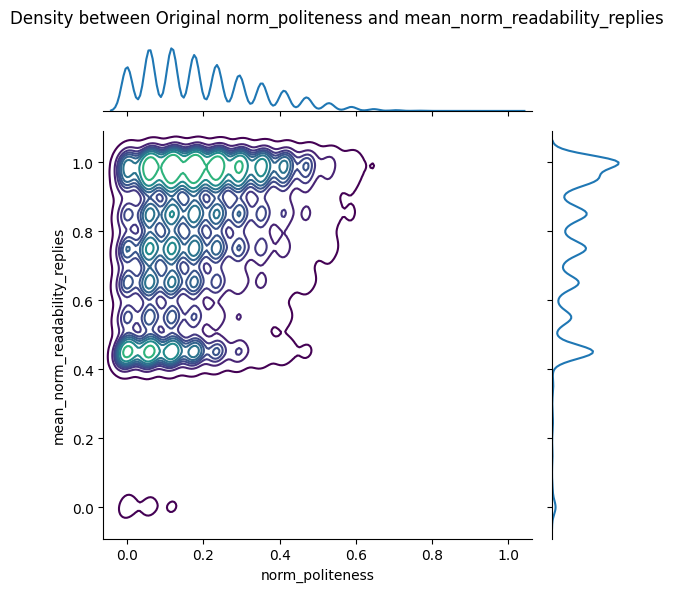

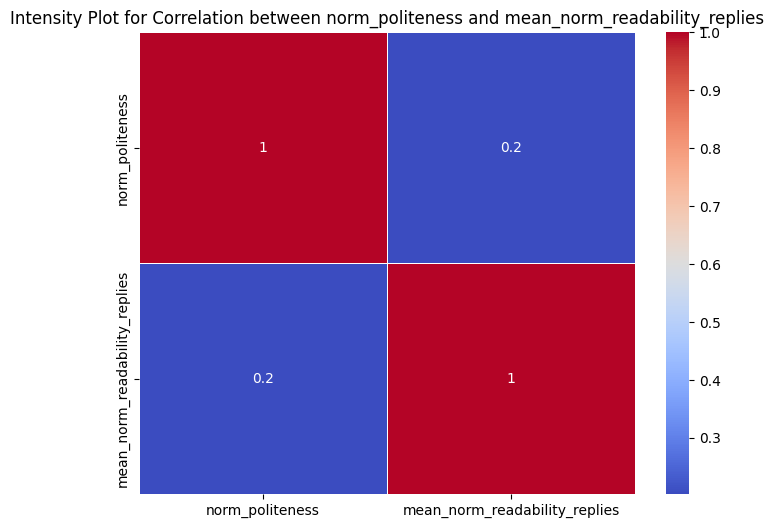

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.041
Model:                            WLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5826.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:40:41   Log-Likelihood:                 68595.
No. Observations:              135904   AIC:                        -1.372e+05
Df Residuals:                  135902   BIC:                        -1.372e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

<Figure size 800x600 with 0 Axes>

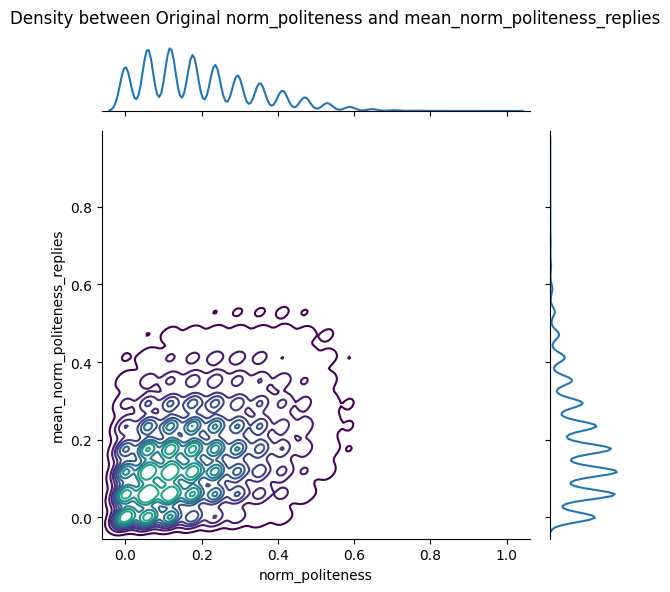

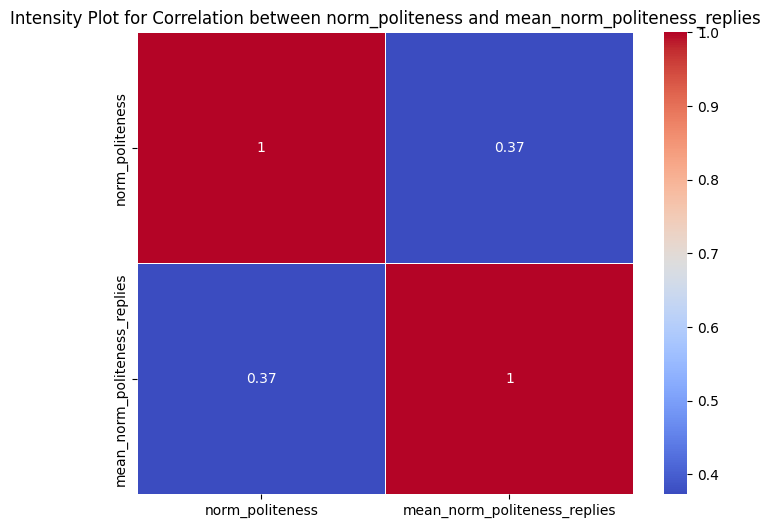

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.139
Model:                            WLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                 2.201e+04
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:42:48   Log-Likelihood:                 75943.
No. Observations:              135904   AIC:                        -1.519e+05
Df Residuals:                  135902   BIC:                        -1.519e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

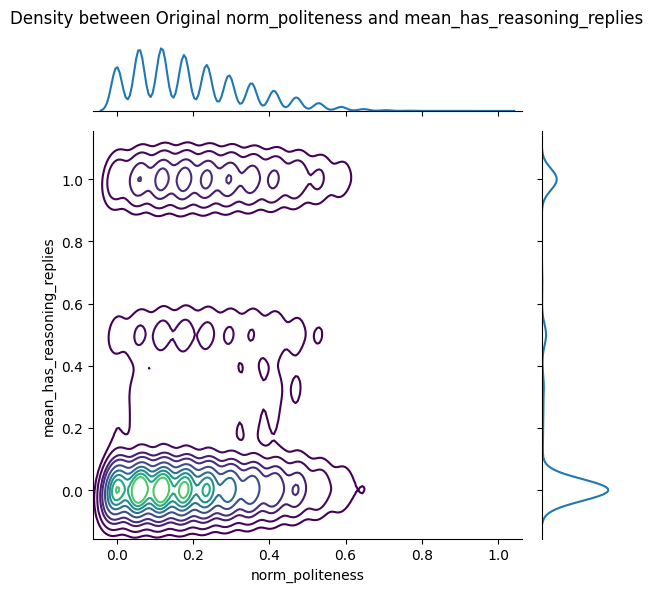

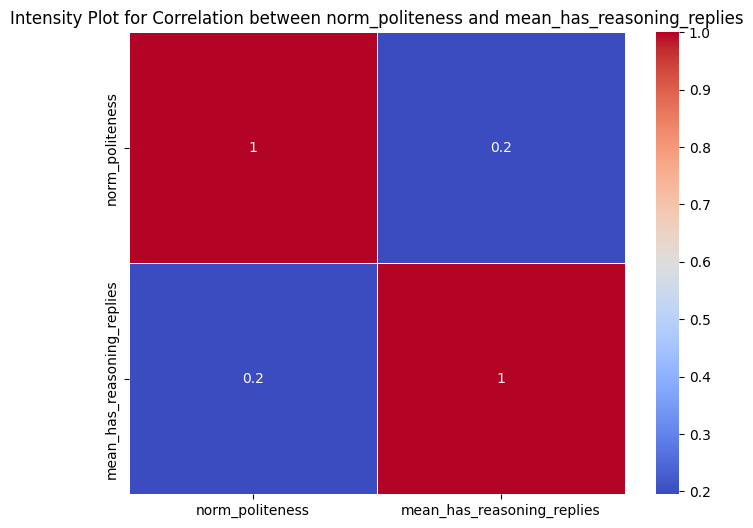

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.038
Model:                            WLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     5383.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:45:08   Log-Likelihood:                 68383.
No. Observations:              135904   AIC:                        -1.368e+05
Df Residuals:                  135902   BIC:                        -1.367e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<Figure size 800x600 with 0 Axes>

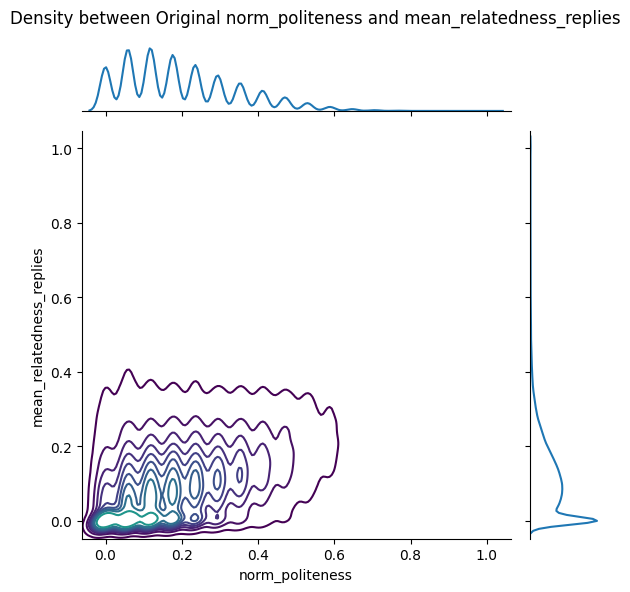

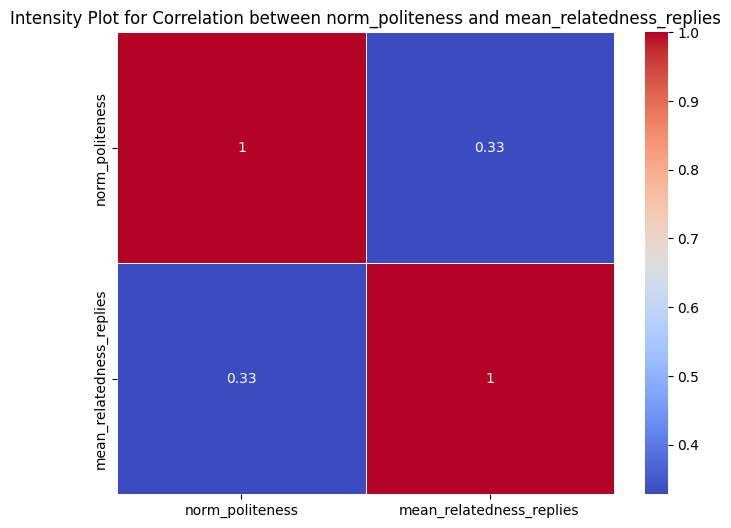

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.108
Model:                            WLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                 1.640e+04
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:47:07   Log-Likelihood:                 73485.
No. Observations:              135904   AIC:                        -1.470e+05
Df Residuals:                  135902   BIC:                        -1.469e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies('norm_politeness')

##Reasoning

Mean of category 1: 0.7518735344114883
Mean of category 2: 0.8092522937558522
t-statistic: -42.191075128473315
p-value: 0.0000
The means are significantly different.


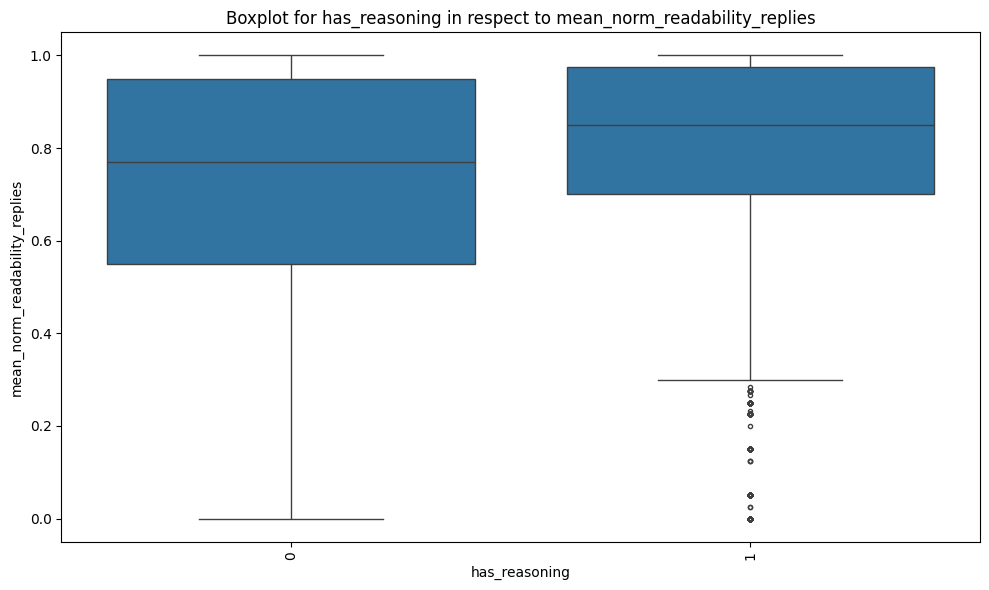

Mean of category 1: 0.16120942157567006
Mean of category 2: 0.22430784673857554
t-statistic: -78.2214190529411
p-value: 0.0000
The means are significantly different.


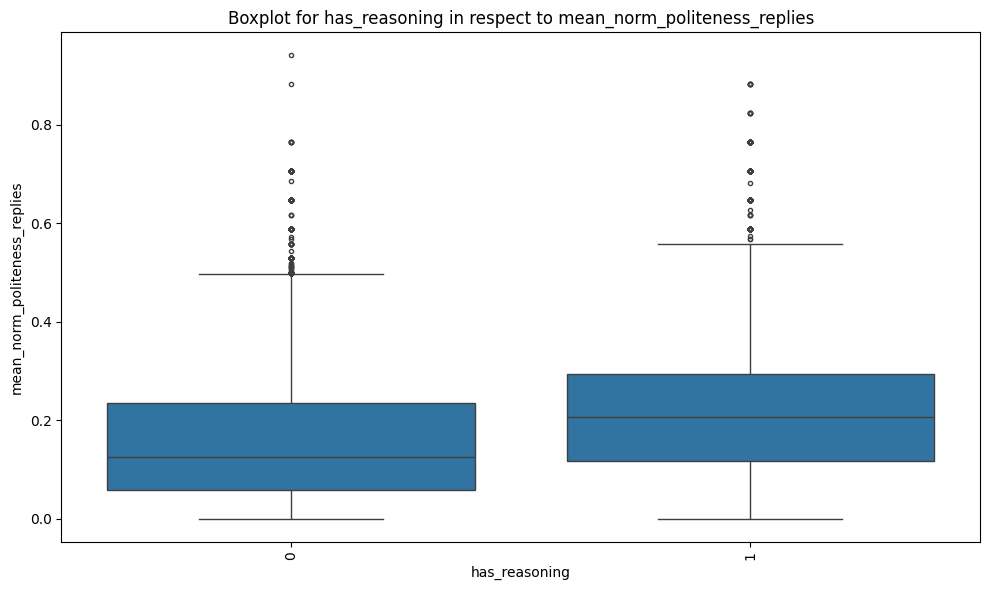

Mean of category 1: 0.1786725397401204
Mean of category 2: 0.3005332401354187
t-statistic: -52.055357197979305
p-value: 0.0000
The means are significantly different.


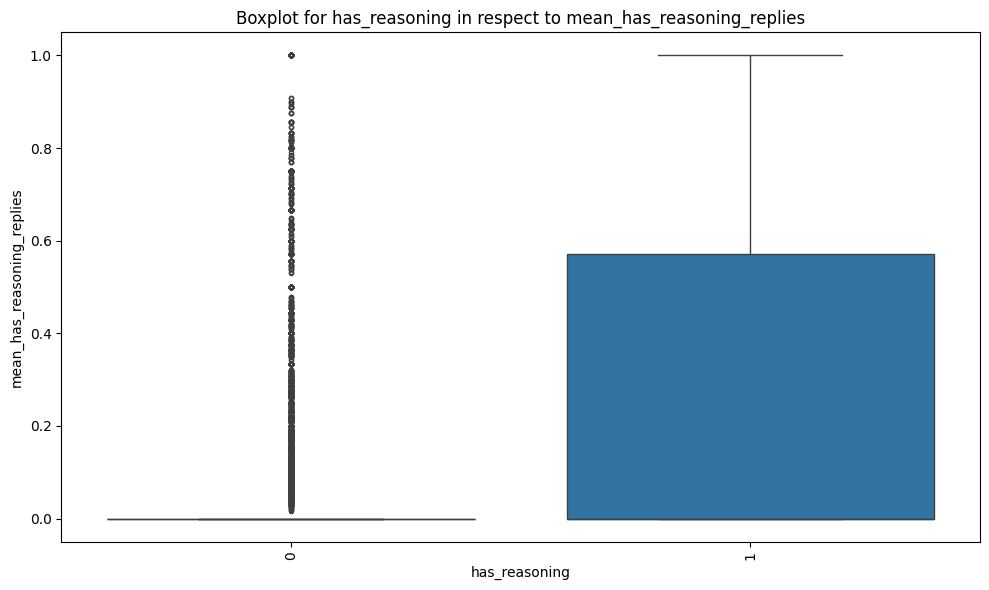

Mean of category 1: 0.11431971280115145
Mean of category 2: 0.13921667278796937
t-statistic: -18.462479084894284
p-value: 0.0000
The means are significantly different.


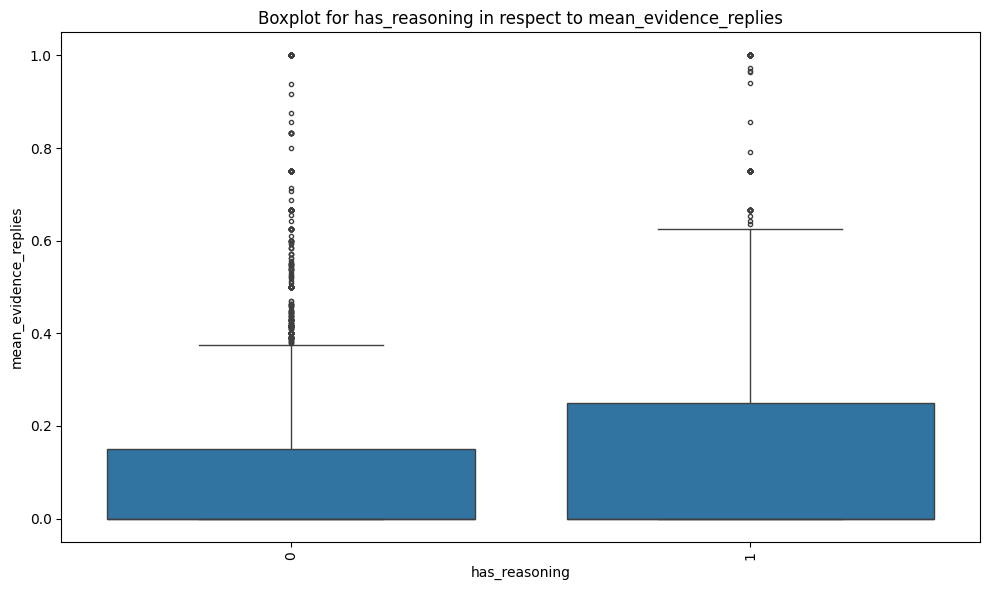

Mean of category 1: 0.10388681814254729
Mean of category 2: 0.15985609532028439
t-statistic: -79.81343798289419
p-value: 0.0000
The means are significantly different.


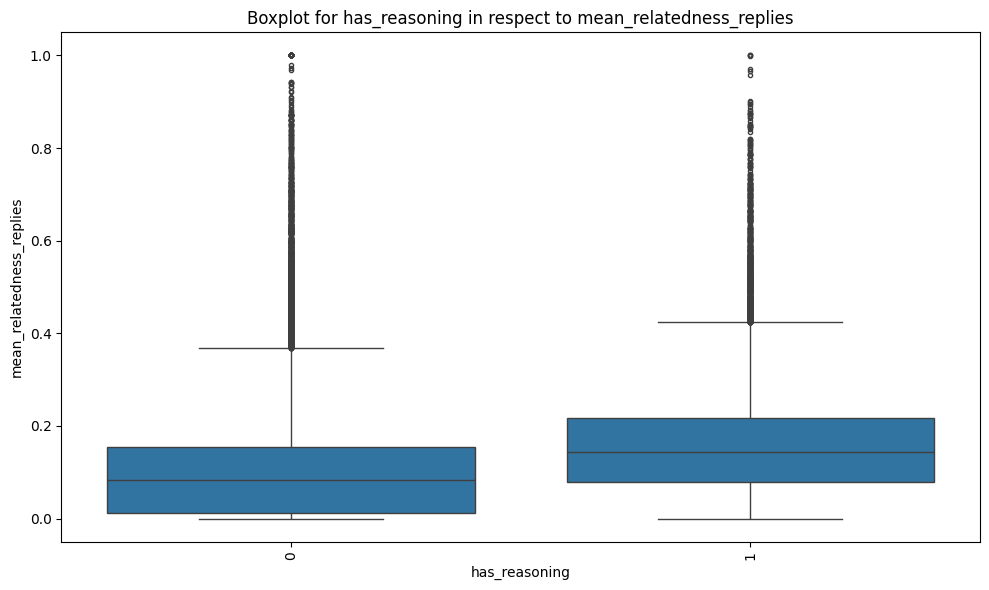

In [108]:
two_sample_ttest_to_mean_replies('has_reasoning', 0, 1)

##Length title

In [ ]:
lm_to_mean_replies('len_title')

Breusch-Pagan Test:
Test Statistic: 0.6356
P-value: 0.4253
Durbin-Watson Statistic: 1.9747
                            OLS Regression Results                            
Dep. Variable:              len_title   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5423
Date:                Tue, 28 May 2024   Prob (F-statistic):              0.461
Time:                        14:40:28   Log-Likelihood:                -93404.
No. Observations:               18165   AIC:                         1.868e+05
Df Residuals:                   18163   BIC:                         1.868e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------

##Text length

Breusch-Pagan Test:
Test Statistic: 0.0373
P-value: 0.8469
Durbin-Watson Statistic: 2.0081
                            OLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     143.0
Date:                Tue, 28 May 2024   Prob (F-statistic):           7.67e-33
Time:                        14:39:32   Log-Likelihood:            -1.5393e+05
No. Observations:               18165   AIC:                         3.079e+05
Df Residuals:                   18163   BIC:                         3.079e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------

<Figure size 800x600 with 0 Axes>

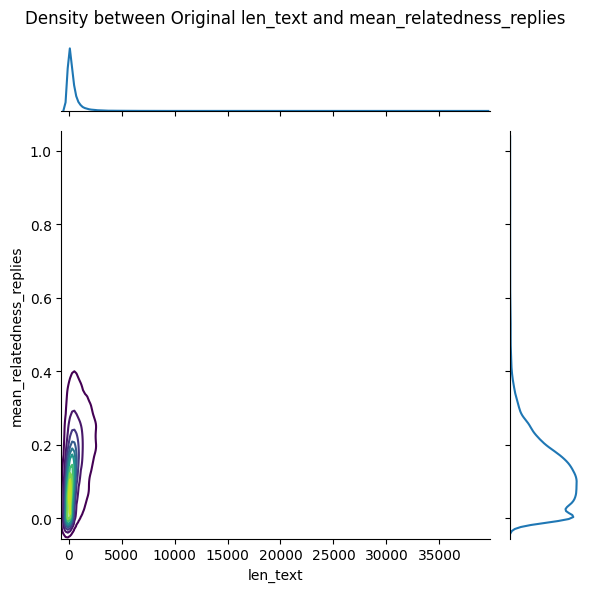

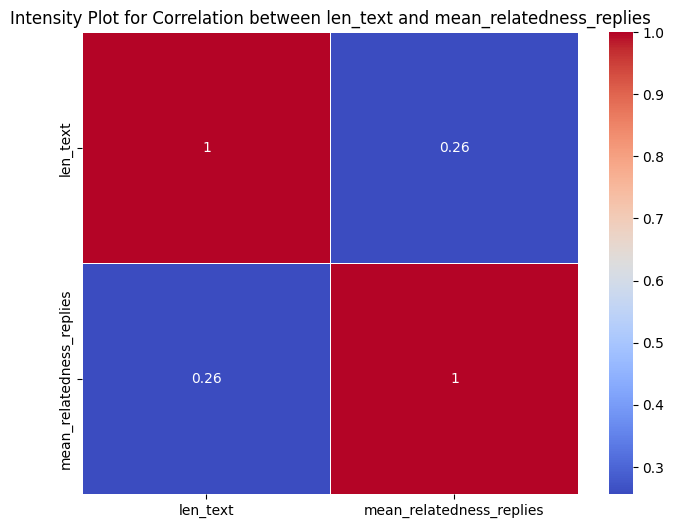

                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.066
Model:                            WLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1276.
Date:                Tue, 28 May 2024   Prob (F-statistic):          4.66e-270
Time:                        14:39:32   Log-Likelihood:            -1.5338e+05
No. Observations:               18165   AIC:                         3.068e+05
Df Residuals:                   18163   BIC:                         3.068e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies('len_text')

##Readability

Breusch-Pagan Test:
Test Statistic: 533.9508
P-value: 0.0000
Durbin-Watson Statistic: 1.9066
relatively signicent!


<Figure size 800x600 with 0 Axes>

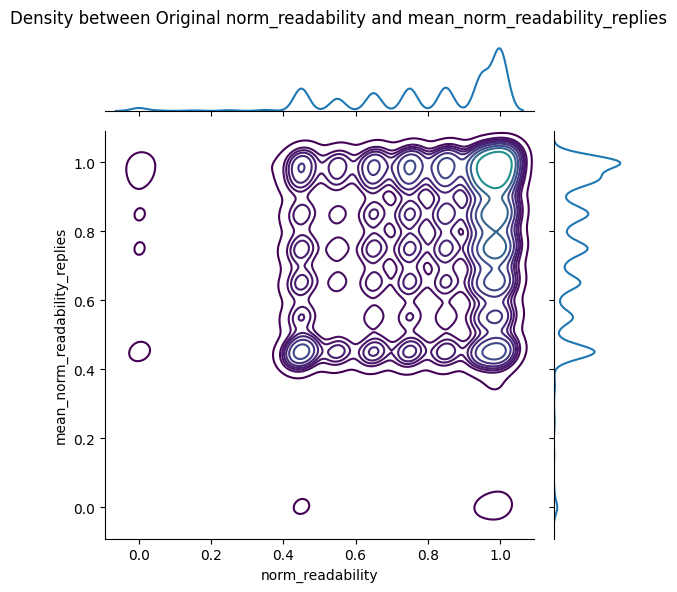

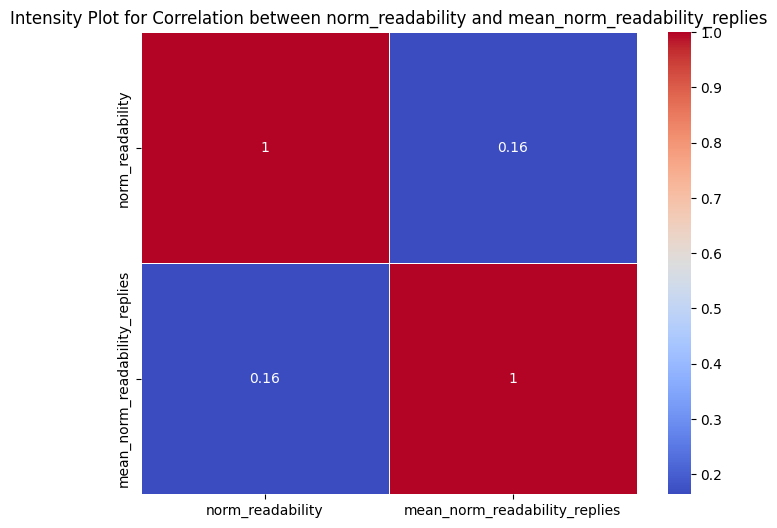

                            WLS Regression Results                            
Dep. Variable:       norm_readability   R-squared:                       0.027
Model:                            WLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3757.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:32:32   Log-Likelihood:                 12535.
No. Observations:              135904   AIC:                        -2.507e+04
Df Residuals:                  135902   BIC:                        -2.505e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

<Figure size 800x600 with 0 Axes>

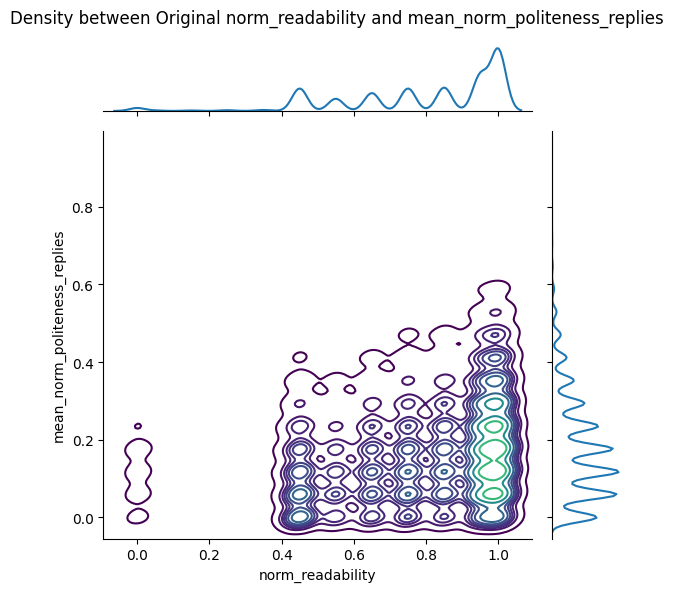

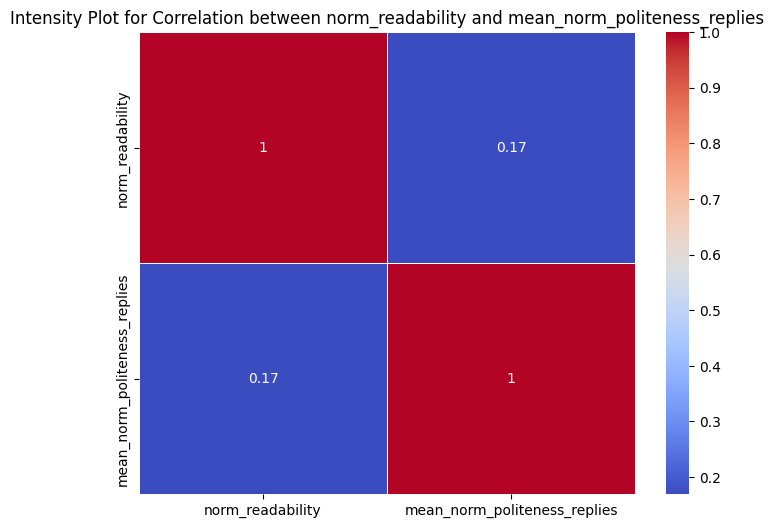

                            WLS Regression Results                            
Dep. Variable:       norm_readability   R-squared:                       0.029
Model:                            WLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     4012.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:34:15   Log-Likelihood:                 12658.
No. Observations:              135904   AIC:                        -2.531e+04
Df Residuals:                  135902   BIC:                        -2.529e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

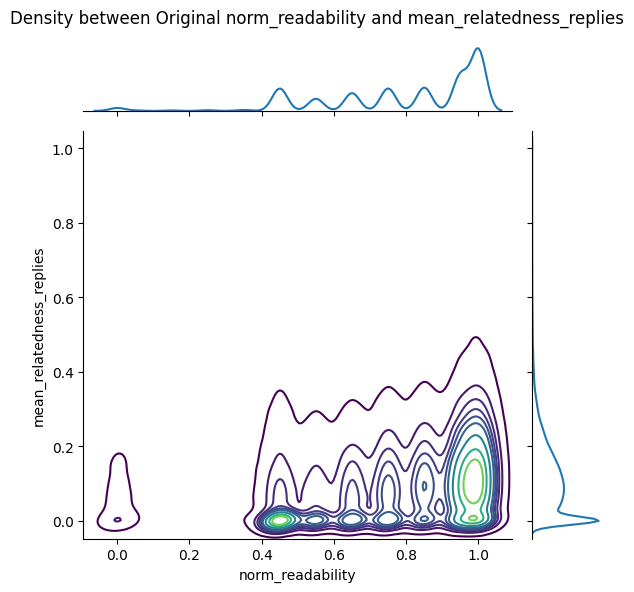

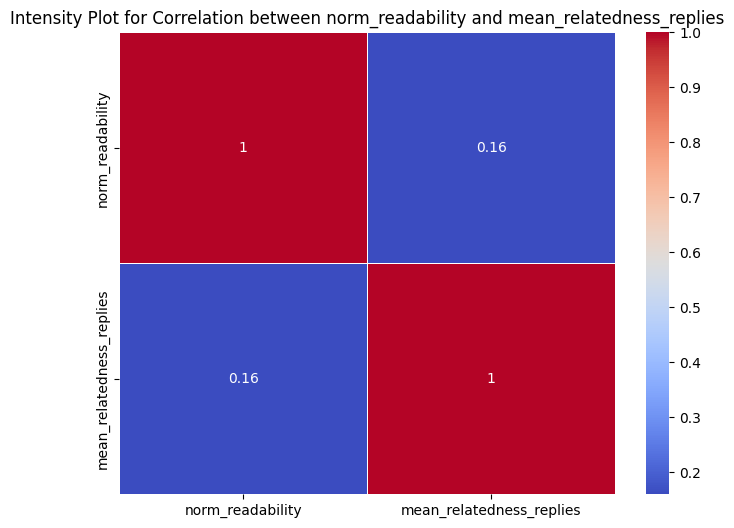

                            OLS Regression Results                            
Dep. Variable:       norm_readability   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3597.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:36:24   Log-Likelihood:                 12457.
No. Observations:              135904   AIC:                        -2.491e+04
Df Residuals:                  135902   BIC:                        -2.489e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies('norm_readability')

##Subreddit

In [ ]:
lm_to_mean_replies('log_subreddit_subscribers')

Breusch-Pagan Test:
Test Statistic: 30.3672
P-value: 0.0000
Durbin-Watson Statistic: 0.3009
                                WLS Regression Results                               
Dep. Variable:     log_subreddit_subscribers   R-squared:                       0.000
Model:                                   WLS   Adj. R-squared:                  0.000
Method:                        Least Squares   F-statistic:                     3.792
Date:                       Tue, 28 May 2024   Prob (F-statistic):             0.0515
Time:                               14:31:34   Log-Likelihood:            -3.1153e+05
No. Observations:                     135808   AIC:                         6.231e+05
Df Residuals:                         135806   BIC:                         6.231e+05
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                                    coef    std 

In [ ]:
lm_to_mean_replies('subreddit_subscribers')

Breusch-Pagan Test:
Test Statistic: 73.2032
P-value: 0.0000
Durbin-Watson Statistic: 0.2742
                              WLS Regression Results                             
Dep. Variable:     subreddit_subscribers   R-squared:                       0.000
Model:                               WLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     37.73
Date:                   Tue, 28 May 2024   Prob (F-statistic):           8.15e-10
Time:                           14:31:27   Log-Likelihood:            -2.3244e+06
No. Observations:                 135808   AIC:                         4.649e+06
Df Residuals:                     135806   BIC:                         4.649e+06
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025   

##Subreddit topic

In [96]:
df['topic'].value_counts()

topic
unknown          170737
media             42584
sport             22037
personal          18061
entertainment     16639
demographic       12484
health             7436
hobby              4569
finance            4321
politic            3690
news               2435
religion           1723
sharing            1272
tech                758
food                715
gaming              678
society             615
education           561
psychology          550
music               475
career              405
community           402
travel              259
Name: count, dtype: int64

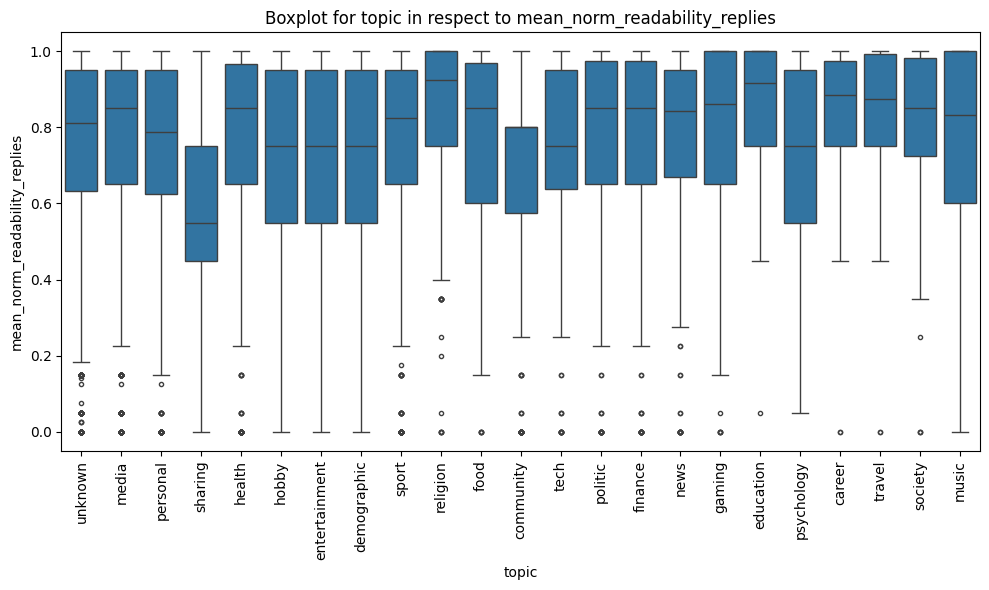

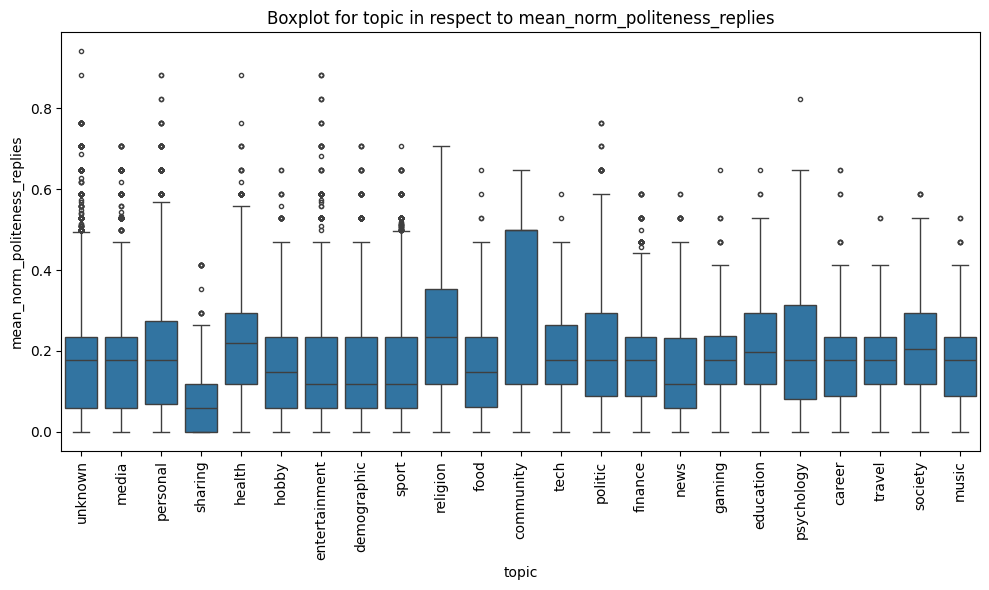

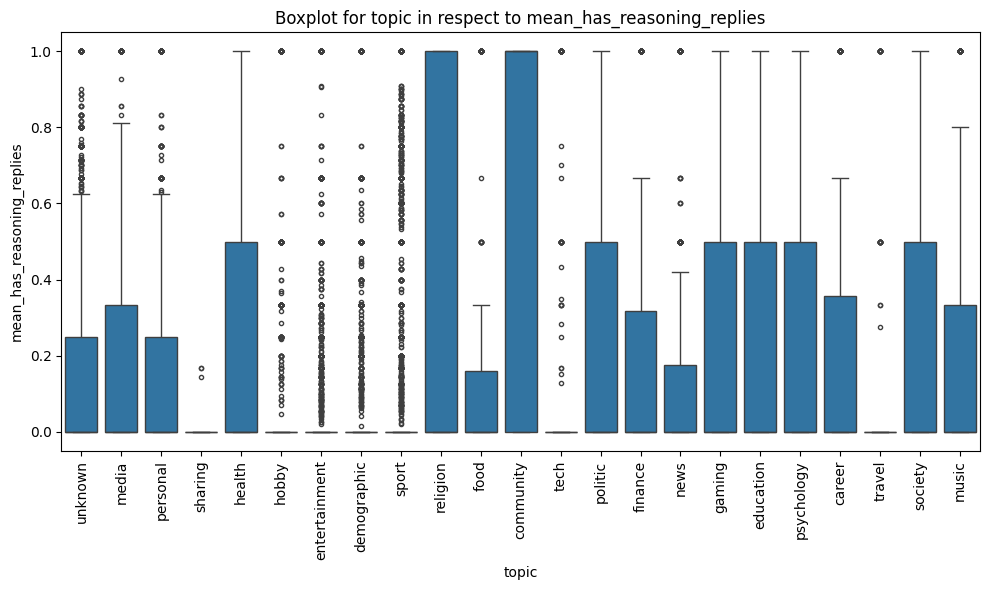

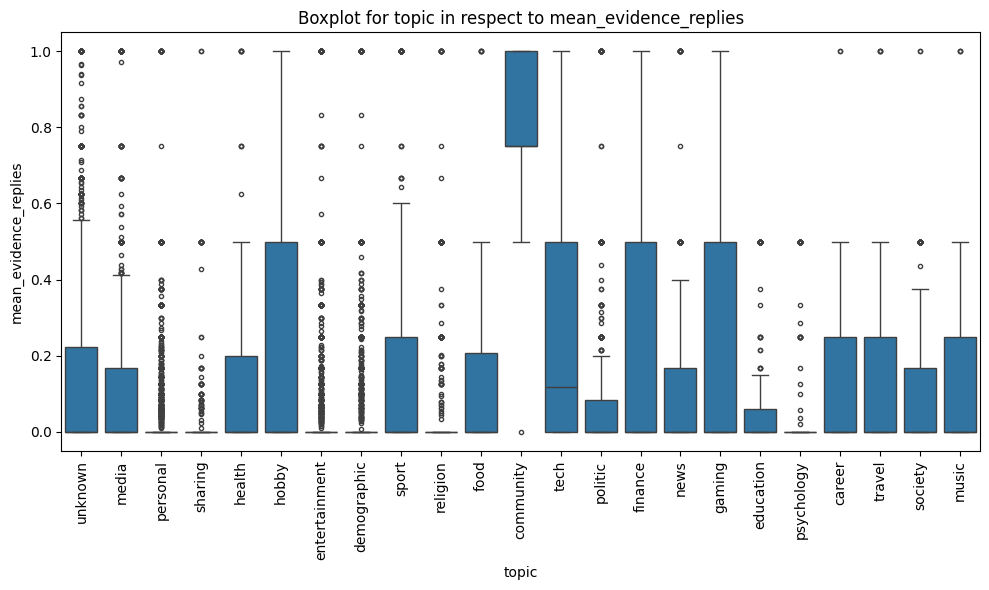

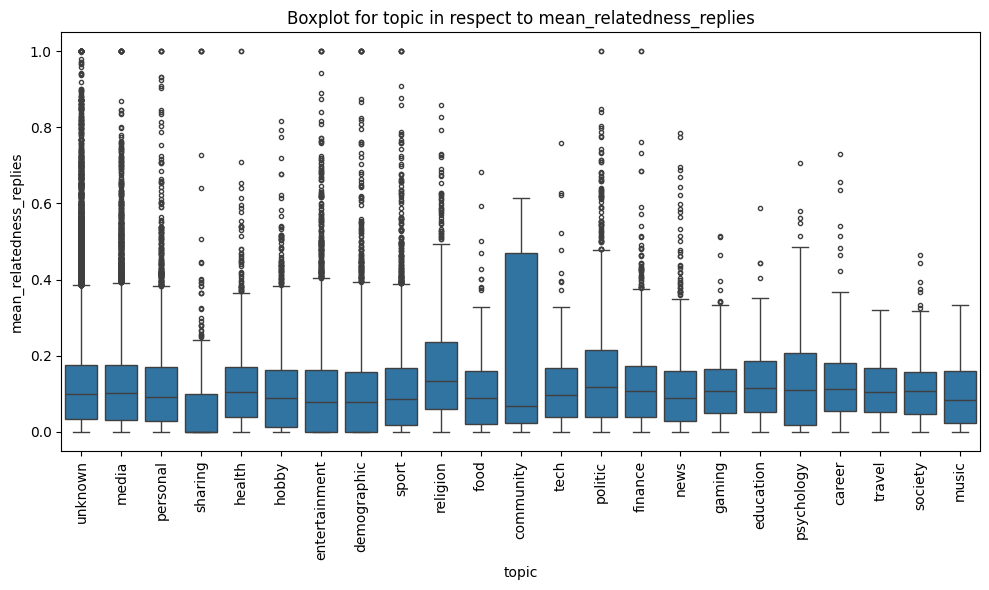

In [97]:
boxplot_to_mean_replies('topic')

In [99]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming df is your DataFrame
# and 'category' is the categorical variable
# and 'numerical_var' is the numerical variable

# Separate the data into two groups based on the category
group1 = df[df['has_reasoning'] == 0]
group2 = df[df['has_reasoning'] == 1]

# Calculate the means of the numerical variable for each group
mean1 = group1['mean_norm_politeness_replies'].dropna().mean()
mean2 = group2['mean_norm_politeness_replies'].dropna().mean()

# Perform the 2-sample t-test
t_stat, p_val = ttest_ind(group1['mean_norm_politeness_replies'].dropna(), group2['mean_norm_politeness_replies'].dropna())

# Print the results
print(f"Mean of category 1: {mean1}")
print(f"Mean of category 2: {mean2}")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")

# Determine if the means are significantly different
if p_val < 0.05:
    print("The means are significantly different.")
else:
    print("The means are not significantly different.")

Mean of category 1: 0.16120942157567006
Mean of category 2: 0.22430784673857554
t-statistic: -78.2214190529411
p-value: 0.0
The means are significantly different.
